# Object tracking in Python

In this session we will build up a workflow to track pre-detected objects through multiple frames of a timeseries.  The images we will be using are of fluorescently-labelled nuclei and are provided by the [Cell Tracking Challenge](http://celltrackingchallenge.net/).

The session is broken down into **N** exercises, each of which will introduce a new step to the workflow.  Typically an exercise will require creation of a new Python function to achieve a specific task (e.g. calculating the cost of linking two points).  At the end of each exercise is a pre-prepared block of code that can be used to test the function is working correctly.

## Exercise 0 - Getting started
### Background
Before we start, we need to make sure this Jupyter Notebook has access to all the functions we're going to use later on.  Many of these will already be included with your Python build; however, a few may be missing.  To deal with this, we first run Pip to download these libraries.  After this, we can do a standard Python import.

### Aim
- Install missing Python libraries
- Import any functions we will use later on

In [1]:
# Running pip against all the libraries we will need.  If these aren't already present, they will be downloaded.
!pip install --user matplotlib
!pip install --user pandas
!pip install --user Pillow
!pip install --user scikit-image

Traceback (most recent call last):
  File "C:\Users\sc13967\AppData\Local\Continuum\anaconda3\Scripts\pip-script.py", line 10, in <module>
    sys.exit(main())
TypeError: 'module' object is not callable
Traceback (most recent call last):
  File "C:\Users\sc13967\AppData\Local\Continuum\anaconda3\Scripts\pip-script.py", line 10, in <module>
    sys.exit(main())
TypeError: 'module' object is not callable
Traceback (most recent call last):
  File "C:\Users\sc13967\AppData\Local\Continuum\anaconda3\Scripts\pip-script.py", line 10, in <module>
    sys.exit(main())
TypeError: 'module' object is not callable
Traceback (most recent call last):
  File "C:\Users\sc13967\AppData\Local\Continuum\anaconda3\Scripts\pip-script.py", line 10, in <module>
    sys.exit(main())
TypeError: 'module' object is not callable


In [2]:
# Importing the libraries into this Notebook
import math
import sys
import util

import numpy as np
import pandas as pd

from scipy.optimize import linear_sum_assignment

In [3]:
# Setting parameters for Jupyter output
np.set_printoptions(precision=2,threshold=sys.maxsize)
pd.options.display.float_format = "{:.2f}".format

In [4]:
# Creating a global variable for "infinity".  This will be needed later on when calculating assignments.
inff = 1000000000

## Exercise 1 - Loading coordinates and visualising
### Background
Our key aim this afternoon is to learn about tracking so we don't want to spend half our time detecting objects to be tracked.  As such, you'll find a pre-prepared CSV file with object coordinates at *../data/UntrackedCoordinates.csv*.  This file has 6 columns: Point ID, x-centroid, y-centroid, timepoint, 2D area and track ID (currently set to 0).  You will need to download the images these coordinates correspond to from the Cell Tracking Challenge website [here](http://data.celltrackingchallenge.net/training-datasets/Fluo-N2DH-GOWT1.zip).  Please unzip this archive, then put the contents of the folder "01" in the *../data/Images/* folder.

We could also sink a couple of hours into creating a script to draw our object coordinates and tracks, but let's not.  For now, I've created a separate script which will load these files for us - this is in the "util.py" file we just imported.  This script also has functions to display the spots on top of the images, so we can check how our tracking is doing.

### Aims
- Load object coordinates from ../data/UntrackedCoordinates.csv into a Pandas dataframe
- Load the timeseries images corresponding to the coordinates into a 3D Numpy array
- Display the first few lines of the coordinate dataframe
- Visualise the coordinates as an overlay on the timeseries images

### Notes
- This exercise doesn't require any code to be written.  It's more about checking the relevant example files can be loaded and the utility functions run as expected.

In [5]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

Loading images from " ../data/Images/ "

Reading image 92 of 92
Loaded image shape:  (256, 256, 92)
Loading coordinates from " ../data/UntrackedCoordinates.csv "
Loaded data shape:  (2058, 6)
 
     ID      X      Y  FRAME    AREA  TRACK_ID
0  1.00  19.58  50.83   0.00 4262.00      0.00
1  2.00  37.00 104.25   0.00 2449.00      0.00
2  3.00  48.50  26.25   0.00 2617.00      0.00
3  4.00  59.66 116.87   0.00 3914.00      0.00
4  5.00  80.75 132.75   0.00 1513.00      0.00
5  6.00  86.43 148.67   0.00 1632.00      0.00
6  7.00  99.00  77.75   0.00 1649.00      0.00
7  8.00 108.88 113.00   0.00 1836.00      0.00
8  9.00 108.50 135.50   0.00 1649.00      0.00
9 10.00 109.25 161.62   0.00 1384.00      0.00

Rendering frame 92 of 92

<IPython.core.display.Javascript object>


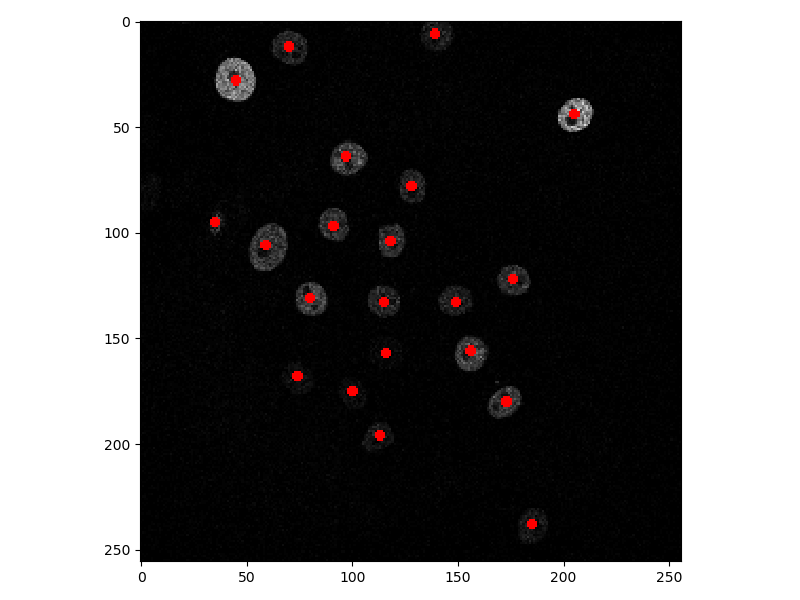

interactive(children=(IntSlider(value=0, description='frame', max=91), Output()), _dom_classes=('widget-intera…

In [6]:
%matplotlib notebook

# Loading image stack
path = "../data/Images/"
images = util.load_images(path);

# Loading coordinates
path = "../data/UntrackedCoordinates.csv"
coords = util.load_coordinates(path);

# Displaying the first 10 lines of the dataframe
print(coords.head(10))
print("")

# Adding track renders
util.show_overlay(images,coords,False)

## Exercise 2 - Extracting coordinates for a specific timepoint
### Background
We have the full list of coordinates, but for tracking we're often going to want to access just those from a specific frame.  The first function we'll create will take the full list of coordinates and return a list of rows corresponding to only those points in the specified frame.

### Aims
- Create a function to get a list of row indicies corresponding to coordinates in a specific frame

In [7]:
# Function to get the row indices for coordinates present in a specific frame.
#
# Args:
#     coords: Pandas dataframe containing all coordinates from all frames.
#     frame: Frame number for which we're getting coordinates.
#
# Returns:
#     A **list** of indices corresponding to the coordinates for the specified frame
#

def get_current_coords(coords, frame):
    # Identifying rows of "coords" with current frame number
    rows = coords.index[coords.FRAME == frame]

    return rows

In [8]:
### TEST SPACE ### 

# Loading coordinates
path = "../data/UntrackedCoordinates.csv"
coords = util.load_coordinates(path);

# Testing on coordinates from frame 0
frame = 0
rows_0 = get_current_coords(coords,frame)
print("Row indices for points in frame 0:\n%a\n" % rows_0)

# Testing on coordinates from frame 1
frame = 1
rows_1 = get_current_coords(coords,frame)
print("Row indices for points in frame 1:\n%a\n" % rows_1)

Loading coordinates from " ../data/UntrackedCoordinates.csv "
Loaded data shape:  (2058, 6)
 
Row indices for points in frame 0:
Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22],
           dtype='int64')

Row indices for points in frame 1:
Int64Index([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
            40, 41, 42, 43, 44, 45],
           dtype='int64')



## Exercise 3 - Assign tracks IDs to the coordinates in the first frame
Eventually, all points will be assigned track IDs.  As we work through all the frames, points will be linked to those in a previous frame and inherit their track IDs.  This way, track ID gets propagated through the timeseries.  To kick things off, we need to assign all points in the first frame unique IDs.  The function we create here will identify any points in a specific frame (for now, frame 0) that don't have assigned track IDs and assign them the smallest, currently unused track ID.  By keeping the function general like this we can reuse it later on when find any points in any frame that didn't get linked back to an existing track.

### Notes
- With Pandas you can get the maximum value in a column using the function "max()".  For example, the following will give the maximum x-value in the whole dataframe:
```Python
    max_x_value = coords.X.max()
```

In [ ]:
# Function to assign unique track ID numbers to any unassigned coordinates at the specified row
# indices.  Unassigned coordinates are identified by a track ID of 0.
#
# Args:
#     coords: Pandas dataframe containing all coordinates from all frames.
#     point_rows: **list* of row indices for tracks to have track IDs assigned.  All, some or 
#                 none of these may need track IDs assigning.
#
# Returns:
#     This function updates the provided coordinate dataframe, so does not return anything.
#

def assign_new_IDs(coords, point_rows):
    # Getting the maximum track ID present in coords
    max_ID = coords.TRACK_ID.max()
    
    # Iterating over all current points and assigning the next available ID if they're still 0
    for point_row in point_rows:
        if coords.TRACK_ID[point_row] == 0:
            max_ID = max_ID + 1
            coords.TRACK_ID.at[point_row] = max_ID
        

In [ ]:
### TEST SPACE ###

# Loading coordinates
path = "../data/UntrackedCoordinates.csv"
coords = util.load_coordinates(path);

# Getting all points in the first frame
frame = 0
rows_0 = get_current_coords(coords,frame)

# Assigning unique track IDs to all these points
assign_new_IDs(coords,rows_0)

# Displaying the first 10 rows of our coordinate dataframe
print(coords.head(10))

## Exercise 4a - Getting all tracks
When assigning track links for each frame, we need to know what tracks are available to link to.  Here, we want to identify the rows corresponding to the most recent instance of each track.

### Notes
- To check our code works it's useful to have some coordinates that have already been tracked.  Therefore, for this exercise, the "coords" dataframe we load has been tracked up to frame 49
- It's possible to get all the unique values in a list using Numpy's "unique" function.  For example, to get the unique values in the list "my_list" we would call:
```Python
    unique_values = np.unique(my_list)
```

In [ ]:
# Function to find the row indices corresponding to the most recent instance of each track.
#
# Args:
#     coords: Pandas dataframe containing all coordinates from all frames.
#
# Returns:
#     A **list** containing the row indices for the most recent instance of each track.
#

def get_all_tracks(coords):    
    # Getting a list of the unique track IDs in our coordinates dataframe
    unique_IDs = np.unique(coords.TRACK_ID)
    
    # Iterating over each track ID, adding the most recent row index to track_rows
    track_rows = []
    for unique_ID in unique_IDs:
        if unique_ID != 0:
            # Getting rows for all instances of this track
            instances = coords.index[coords.TRACK_ID == unique_ID]    
            
            # Getting most recent instance of this track and appending it to final_rows
            track_rows.append(instances[-1:][0])
                    
    return track_rows

In [ ]:
### TEST SPACE ### 

# Loading coordinates
path = "../data/PartiallyTrackedCoordinates.csv"
coords = util.load_coordinates(path);

# Getting row indices for all available tracks
track_rows = get_all_tracks(coords)

# Displaying the points we have identified
print("Identified %i available tracks" % len(track_rows))
print("")
print(coords.loc[track_rows])

## Exercise 4b - Getting all AVAILABLE tracks
In the first half of this exercise we identified the most recent instance of each track.  However, we may also choose to only allow links to tracks identified within a specific number of frames.  For example, we may not want to allow a point in frame 42 to link back to a track last seen in frame 9.

### Notes
- As before, we'll load the partially-tracked coordinates.

In [ ]:
# Function to find the row indices corresponding to the most recent instance of each track.
# This will only return row indices for tracks present within a specified frame range.
#
# Args:
#     coords: Pandas dataframe containing all coordinates from all frames
#     start_frame: First frame of range for which tracks are considered "available" for linking to
#     end_frame: Final frame of range for which tracks are considered "available" for linking to.  This
#                will typically be the frame immediately prior to the "current" frame.
#
# Returns:
#     A **list** containing the row indices for the most recent instance of each available track.
#

def get_available_tracks(coords, start_frame, end_frame):
    # Getting all rows present within the specified time interval
    rows = coords.index[(coords.FRAME >= start_frame) & (coords.FRAME <= end_frame)]
    
    # Getting the most recent instance of this track
    available_rows = []
    unique_IDs = np.unique(coords.TRACK_ID[rows])
    for unique_ID in unique_IDs:
        if unique_ID != 0:
            # Getting rows for all instances of this track
            instances = coords.index[(coords.TRACK_ID == unique_ID) 
                & (coords.FRAME >= start_frame) & (coords.FRAME <= end_frame)]    
            
            # Getting most recent instance of this track and appending it to final_rows
            available_rows.append(instances[-1:][0])
                    
    return available_rows

In [ ]:
### TEST SPACE ### 

# Loading coordinates
path = "../data/TrackedCoordinates.csv"
coords = util.load_coordinates(path);

# Getting row indices for all available tracks
start_frame = 44
end_frame = 49
track_rows = get_available_tracks(coords,start_frame,end_frame)

# Displaying the points we have identified
print("Identified %i available tracks" % len(track_rows))
print("")
print(coords.loc[track_rows])

## Exercise 5 - Calculating cost for linking two points
In a couple of steps we will end up with two lists: one for points in the current frame; the other for the most recent point in all available tracks.  Links between the points in the two lists will be assigned based on the cost associated with making that link.  Here, we want to create a function that will calculate the cost associated with two given points.  To start with, we will just calculate the cost as the distance between the two points, but we could also add costs associated with other metrics.  For example, we may want to penalise links which would see the size or intensity of the object change too much.

**Add a figure demonstrating mislinking objects of different sizes, then how a size-change term could favour correct assignment**

### Notes
- For this we'll load in the full set of coordinates, but only calculate the cost for the first points in frame 1 and frame 2.

In [ ]:
# Function to calculate the cost of linking two points.  This function simply calculates the cost as 
# the distance between the two points.
#
# Args:
#     coords: Pandas dataframe containing all coordinates from all frames
#     track_row: Row index for the most recent coordinate in a track
#     point_row: Row index for a coordinate in the current frame
#     thresh: Maximum permitted distance between two points.  If points are separated by more than this
#             the cost will be assigned a very large value to ensure a very low probability of the link
#             being assigned by the Munkres algorithm.
#
# Returns:
#     A floating point (decimal) value corresponding to the cost of linking the two specified points.
#

def calculate_cost(coords,track_row,point_row,thresh):
    # Spatial linking (distance between two points)
    dx = coords.X[point_row] - coords.X[track_row]
    dy = coords.Y[point_row] - coords.Y[track_row]
    d = float(math.sqrt(float(dx*dx + dy*dy)))

    # If the two points are separated by more than the linking threshold, set them to infinity ('inf')
    if d > thresh:
        d = inff
    
    return d

In [ ]:
### TEST SPACE ### 

# Loading coordinates
path = "../data/UntrackedCoordinates.csv"
coords = util.load_coordinates(path);

# Let's get the indices for the coordinates in the first frame
rows_0 = get_current_coords(coords,0)

# For this cost calculation we'll just use the first coordinate in this frame
row_0 = rows_0[0]

# Let's take a look at that coordinate
print("Coordinate 1:\n%a\n" % coords.loc[row_0])

# Now, let's do the same for the second frame
rows_1 = get_current_coords(coords,1)
row_1 = rows_1[0]
print("Coordinate 2:\n%a\n" % coords.loc[row_1])

# Calculating the cost of the two points with the threshold set high
thresh = 10;
cost = calculate_cost(coords,row_0,row_1,thresh)
print("Cost = %f (thresh = %f)" % (cost,thresh))

# Now, we'll do the same, but with a lower threshold
thresh = 0.5;
cost = calculate_cost(coords,row_0,row_1,thresh)
print("Cost = %f (thresh = %f)" % (cost,thresh))

## Exercise 6 - Calculate cost matrix
Now we can calculate the cost for a single pair of points we need to do it for all point pairs.  We will create a function which takes the points in the current frame and the available track points, then generates a 2D cost matrix.  The cost matrix will have a column for each point in the current frame and a row for each available track.  The value of each element will therefore be the cost of linking the point and track corresponding to that column and row.  We also want to limit the distance that links can be made over; therefore, any point-track pairs separations that are greater than a specific distance will be set to infinity.  This doesn't prevent them being linked (if there are no better options, the assignment algorithm will still suggest that as a link), but it makes it less likely.

### Notes
- So we can easily see how this is working, we'll load a special set of coordinates.  This set only has 3 points in the first frame and 4 points in the second frame.
- **Talk about enumerate function to get index of current iteration**

In [ ]:
# Function to calculate the cost of linking all points specified by two **lists** of row indices.  The
# first **list** of indices corresponds to the most recent coordinates in each available track.  The 
# second **list* of indices corresponds to the coordinates in the current frame.  Costs are added to a 
# 2D Numpy array.
#
# Args:
#     coords: Pandas dataframe containing all coordinates from all frames
#     track_rows: Row indices for the most recent coordinate in all available tracks
#     point_rows: Row indices for all coordinates in the current frame
#     thresh: Maximum permitted distance between two points.  If points are separated by more than this
#             the cost will be assigned a very large value to ensure a very low probability of the link
#             being assigned by the Munkres algorithm.
#
# Returns:
#     A 2D Numpy array containing all costs.  Each row of the array corresponds to a track and each column
#     to a current coordinate.  The intersection of each row and column is the associated cost.
#

def calculate_dense_cost_matrix(coords,track_rows,point_rows,thresh):
    # Creating the empty array
    costs = np.empty((len(track_rows),len(point_rows)))
        
    # Iterating over each pair, calculating the cost
    for track_i, track_row in enumerate(track_rows):
        for point_i,point_row in enumerate(point_rows):            
            cost = calculate_cost(coords,track_row,point_row,thresh)
            costs[track_i,point_i] = cost
           
    return costs

In [ ]:
### TEST SPACE ### 

# Loading coordinates
path = "../data/TestCoordinatesForCostMatrix.csv"
coords = util.load_coordinates(path);

# Let's get the indices for the coordinates in the first (available tracks) and second (current points) frames
track_rows = get_current_coords(coords,0)
point_rows = get_current_coords(coords,1)

# Calculating the cost matrix
thresh = 20
costs = calculate_dense_cost_matrix(coords,track_rows,point_rows,thresh)

# Displaying our costs
print("Cost matrix:\n%a\n" % costs)

## Exercise 7 - Calculate assignments
The job of calculating the assignments is done using the Munkres (aka. Kuhn-Munkres or Hungarian) algorithm.  Rather than create our own implementation of this, we will use SciPy's linear_sum_assignment function.  This algorithm simply takes the cost matrix we just created and outputs a **list** of the assignments.  For each row of the assignment result the first column value corresponds to the track and the second column to the linked coordinate.  

/////Each element of this list corresponds to a **row** (**i.e. current point**) in the cost matrix, while the value of that element corresponds to the assigned **column** (**i.e. track**).  We use this list of assignments to assign the current points the correct track ID.  As mentioned previously, the Munkres algorithm will still assign links that we set to infinity, so before we copy over any track IDs we want to double check the cost is not infinity./////

### Notes
- For this example we'll go back to using the partially-tracked example coordinates.  This dataset has tracks assigned up to frame 49; therefore, we'll calculate the assignments for frame 50.  By using the partially-tracked dataset we can start to put together many of the functions we've created so far: 
    - Getting available tracks
    - Getting coordinates from the current frame
    - Calculating the cost matrix
    - Calculating assignments
    - Inheriting track IDs from assigned tracks
    - Creating new track IDs for unlinked points
- We'll only permit linking to tracks last seen within 5 frames of the current frame

In [ ]:
# Function to assign links between two sets of coordinates based on provided costs.
#
# Args:
#     coords: Pandas dataframe containing all coordinates from all frames
#     track_rows: Row indices for the most recent coordinate in all available tracks
#     point_rows: Row indices for all coordinates in the current frame
#     costs: 2D Numpy array containing all costs.  Each row of the array corresponds to a track and each 
#            column to a current coordinate.  The intersection of each row and column is the associated cost.
#
# Returns:
#     This function updates the provided coordinate dataframe, so does not return anything.
#

def assign_IDs(coords, track_rows, point_rows, costs):
    # Using SciPy's linear_sum_assignment function to assign optimal links
    assignments = linear_sum_assignment(costs)
        
    for track_assignment, point_assignment in zip(assignments[0],assignments[1]):
        # Even though we set disallowed costs to 1000000000, if there are no better options, Munkres will still 
        # assign these. We need to check if the assignment corresponds to one of these disallowed assignments.
        if costs[track_assignment,point_assignment] < inff:
            ID = coords.TRACK_ID[track_rows[track_assignment]]
            coords.TRACK_ID.at[point_rows[point_assignment]] = ID

In [ ]:
### TEST SPACE ### 

# Loading coordinates
path = "../data/PartiallyTrackedCoordinates.csv"
coords = util.load_coordinates(path);

# Setting some parameters
frame = 50
frame_thresh = 5
linking_thresh = 10

# Getting available tracks at frame 11.  We'll only allow links back 5 frames
start_frame = frame - frame_thresh
end_frame = frame - 1
track_rows = get_available_tracks(coords,start_frame,end_frame)

# Getting row indices for points in frame 11
point_rows = get_current_coords(coords,frame)

# Calculating cost matrix
costs = calculate_dense_cost_matrix(coords,track_rows,point_rows,linking_thresh)

# Calculating assignments using SciPy's linear_sum_assignment
assign_IDs(coords, track_rows, point_rows, costs)

# Displaying the coordinates for the current frame (with new assigned track IDs)
print("Coordinates after linking:\n%a\n" % coords.loc[point_rows])

# Assigning new track IDs to points that weren't linked
assign_new_IDs(coords,point_rows)
print("Coordinates after new track creation:\n%a\n" % coords.loc[point_rows])

## Exercise 8 - Putting it all together
We now have all the components necessary to construct a full tracking workflow.  For this, we put most of the components in a single for-loop, which will iterate over each frame.  At the end of this we will re-render the overlay to see if our tracking has worked correctly.  Unlike previous exercises, you don't need to create new functions here - you have everything you need.  The aim is to load the full coordinate set, then iterate over each frame, tracking the coordinates.

In [ ]:
### TEST SPACE ### 

# First, a bit of housekeeping, so we can display the overlaid tracks later on
%matplotlib notebook

# Setting parameters
np.set_printoptions(precision=3,threshold=sys.maxsize)

linking_thresh = 10
frame_thresh = 5

# Loading image stack
path = "../data/Images/"
images = util.load_images(path);

# Loading coordinates
path = "../data/UntrackedCoordinates.csv"
coords = util.load_coordinates(path);

# Assigning unique track IDs to points in the first frame
rows_0 = get_current_coords(coords,0)
assign_new_IDs(coords,rows_0)

# Getting the number of frames
n_frames = images.shape[2]

# Starting at frame 2, looping over each frame, linking pairs
for frame in range (1,n_frames):    
    sys.stdout.write("\rProcessing frame %i" % frame)
    
    start_frame = frame - frame_thresh
    end_frame = frame-1
    
    track_rows = get_available_tracks(coords,start_frame,end_frame)

    # Getting row indices for points in current frame
    point_rows = get_current_coords(coords,frame)

    # Calculating cost matrix
    thresh = 10
    costs = calculate_dense_cost_matrix(coords,track_rows,point_rows,thresh)

    # Calculating assignments using SciPy's linear_sum_assignment
    assign_IDs(coords, track_rows, point_rows, costs)

    # Assigning new track IDs to points that weren't linked
    assign_new_IDs(coords,point_rows)

In [ ]:
# Adding track renders
util.show_overlay(images,coords,True)

## Exercise 9 - Quantifying our tracks
With a fully tracked set of coordinates we probably want to make some measurements.  Here we will look at a few common metrics.